## Kalman filter with neural network driven dynamic

In this notebook, we solve a unknow dynamic Kalman filter problem by using the neural network driven inference. This filter is conducted in the Lorenz system. The Lorenz system is a system of ordinary differential equations first studied by Edward Lorenz. From a technical standpoint, the Lorenz system is nonlinear, aperiodic, three-dimensional and deterministic. 

The purpose of the filtering is to compute the marginal posterior distribution or filtering distribution of the state $x_k$ at each time step $k$ given the history of the measurements up to the time step k:
$$
p(x_k | y_{1:k}).
$$ 

In [2]:
using Pkg; Pkg.activate("../..")

  Activating project at `~/Documents/GitHub/ReactiveMP.jl`


In [3]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using BenchmarkTools
using Flux
using ReverseDiff
using Random
using Plots
using LinearAlgebra

In [4]:
Random.seed!(1234);

## Generate data

In [5]:
# Lorenz system equations to be used to generate dataset
Base.@kwdef mutable struct Lorenz
    dt::Float64
    σ::Float64
    ρ::Float64
    β::Float64
    x::Float64
    y::Float64
    z::Float64
end

function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x);         l.x += l.dt * dx
    dy = l.x * (l.ρ - l.z) - l.y;   l.y += l.dt * dy
    dz = l.x * l.y - l.β * l.z;     l.z += l.dt * dz
end
;

In [6]:
#Dataset
ordered_dataset = []
ordered_parameters = []

for σ = 11:15
    for ρ = 23:27
        for β_nom = 6:9
            attractor = Lorenz(0.02, σ, ρ, β_nom/3.0, 1, 1, 1)
            noise_free_data = [[1.0, 1.0, 1.0]]
            for i=1:99
                step!(attractor)
                push!(noise_free_data, [attractor.x, attractor.y, attractor.z])
            end
            push!(ordered_dataset, noise_free_data)
            push!(ordered_parameters, [σ, ρ, β_nom/3.0])
        end
    end
end

new_order = collect(1:100)
shuffle!(new_order)

dataset = [] #noisy dataset
noise_free_dataset = [] #noise free dataset
lorenz_parameters = []

for i in new_order
    data = []
    push!(noise_free_dataset, ordered_dataset[i])
    push!(lorenz_parameters, ordered_parameters[i])
    for nfd in ordered_dataset[i]
        push!(data,nfd+randn(3))
    end
    push!(dataset, data)
end

trainset = dataset[1:60]
validset = dataset[61:80]
testset = dataset[81:end]

noise_free_trainset = noise_free_dataset[1:60]
noise_free_validset = noise_free_dataset[61:80]
noise_free_testset = noise_free_dataset[81:end]
;

### Let's visualize our data

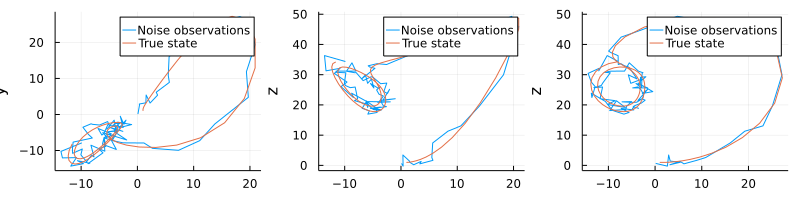

In [70]:
one_nonoise=noise_free_trainset[1]
one=trainset[1]

gx, gy, gz = zeros(100), zeros(100), zeros(100)
rx, ry, rz = zeros(100), zeros(100), zeros(100)

for i=1:100
    rx[i], ry[i], rz[i] = one[i][1], one[i][2], one[i][3]
    gx[i], gy[i], gz[i] = one_nonoise[i][1], one_nonoise[i][2], one_nonoise[i][3]

end
p1=plot(rx,ry,label="Noise observations")
p1=plot!(gx,gy,label="True state")
xlabel!("x")
ylabel!("y")

p2=plot(rx,rz,label="Noise observations")
p2=plot!(gx,gz,label="True state")
xlabel!("x")
ylabel!("z")

p3=plot(ry,rz,label="Noise observations")
p3=plot!(gy,gz,label="True state")
xlabel!("y")
ylabel!("z")

plot(p1, p2, p3, size = (800, 200),layout=(1,3))

### Inference for filtering

Bayesian filtering is considered with state estimation in general probabilistic state space models which have the following form:
$$
x_k \sim p(x_k | x_{k-1}) \\
y_k \sim p(y_k | x_k).
$$
where $x_k \sim p(x_k | x_{k-1})$ is the dynamic model which describes the stochastic dynamics of the system. If the dynamic model is know or explicit, the filtering solutions can be calculated by Chapman–Kolmogorov equation in "Bayesian Filtering and Smoothing". However, for Lorenz system, the dynamic model is nonlinear and hard to descibe. Hence, we develop a neural network to fomulate the dynamics of Lorenz system.
$$
p(x_k | x_{k-1})=\mathcal{N}(x_k | A_{k-1}*x_{k-1}, Q) \\
A_{k-1}=NN(y_{k-1})
$$
where $NN$ is the neural network. The input is the observation $y_{k-1}$, and output is the trasition matrix $A_{k-1}$.

In [7]:
#Neural Network model
mutable struct NN
    InputLayer
    OutputLater
    g
    params

    function NN(W1,b1,W3,b3)
        InputLayer = Dense(W1, b1, relu)
        # Lstm = LSTM(W2_1,W2_2,b2,s2_1,s2_2)
        OutputLayer = Dense(W3, b3)
        g = Chain(InputLayer, OutputLayer);
        new(InputLayer, OutputLayer, g, (W1,b1,W3,b3))
    end
end

We treat trasition matrix $A_{k-1}$ as a datavar in ReactiveMP and develop the following state space model.

In [8]:
#State Space Model
@model function ssm(n, As, Q::ConstVariable, B::ConstVariable, R::ConstVariable)
   
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior_mean = zeros(3)
    x_prior_cov  = Matrix(Diagonal(ones(3)))
    
    x[1] ~ MvNormalMeanCovariance(x_prior_mean, x_prior_cov)
    y[1] ~ MvNormalMeanCovariance(B * x[1], R) where { q = q(mean)q(out)q(cov) }
    
    for i in 2:n
        x[i] ~ MvNormalMeanCovariance(As[i - 1] * x[i - 1], Q) where { q = q(mean, out)q(cov) }
        y[i] ~ MvNormalMeanCovariance(B * x[i], R) where { q = q(mean)q(out)q(cov) }
    end
    
    return x, y
end

We set the Covariance of dynamic model and measurement model as identity matrix. And we define the measurement model as $p(y_k | x_k)=\mathcal{N}(y_k | B*x_k, R)$, where B is the identity matrix.

In [9]:
Q = Matrix(Diagonal(ones(3)))
B = Matrix(Diagonal(ones(3)))
R = Matrix(Diagonal(ones(3)))
;

We use inference function to infer the hidden state $x_k$, and calculate the Free Energy.

In [10]:
function inference(data, W1,b1,W3,b3)
    n = length(data)
    
    neural = NN(W1,b1,W3,b3)
    Flux.reset!(neural)
    
    # As  = map((d) -> Diagonal(neural.g(d)), data[1:end-1])
    As  = map((d) -> Matrix(Diagonal(neural.g(d))), data[1:end-1])
    
    model, (x, y) = ssm(n, As, Q, B, R)
    
    x_buffer = Vector{Marginal}(undef, n)
    fe_value = nothing
    
    x_subscription = subscribe!(getmarginals(x), (xs) -> copyto!(x_buffer, xs))
    f_subscription = subscribe!(score(BetheFreeEnergy(), model, AsapScheduler()), (fe) -> fe_value = fe)
    
    for i in 1:n
        update!(y[i], data[i])
    end
    
    unsubscribe!(x_subscription)
    unsubscribe!(f_subscription)
    Flux.reset!(neural)
    
    return x_buffer, fe_value
end

inference (generic function with 1 method)

The weights of neural network $NN$ are initialized.

In [11]:
# Initial model parameters
W1, b1 = randn(5,3)./100, randn(5)./100
# W2_1, W2_2, b2, s2_1, s2_2 = randn(5 * 4, 5)./100, randn(5 * 4, 5)./100, randn(5*4)./100, zeros(5), zeros(5)
W3, b3 = randn(3,5)./100, randn(3)./100
;

Before network training, we shown the inference results of hidden states.

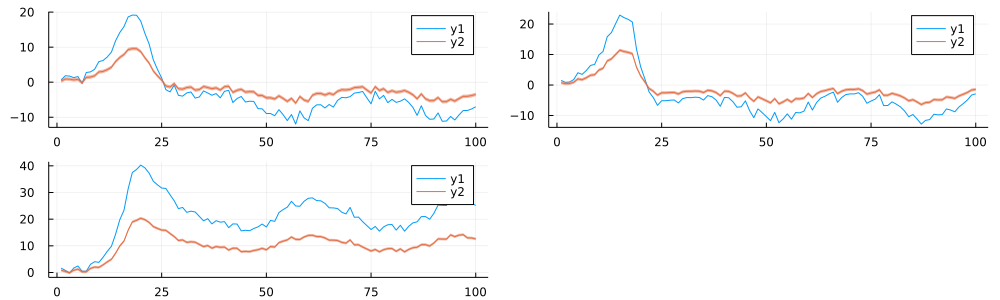

In [12]:
# Performance on an instance from the testset before training
index = 1
x_est, f_est = inference(testset[index], W1,b1,W3,b3)

rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

p1 = plot(rx)
p1 = plot!(rx_est_m, ribbon=rx_est_var)

p2 = plot(ry)
p2 = plot!(ry_est_m, ribbon=ry_est_var)

p3 = plot(rz)
p3 = plot!(rz_est_m, ribbon=rz_est_var)

plot(p1, p2, p3, size = (1000, 300))

### Training network

In this part, we use the calculated Free Energy as the objective function to optimize the weights of network.

In [13]:
# free energy objective to be optimized during training
function fe_tot_est(W1,b1,W3,b3)
    fe_ = 0
    for train_instance in trainset
        fe_est(W1,b1,W3,b3) = begin xm, fe = inference(train_instance, W1,b1,W3,b3); fe end
        fe_ += fe_est(W1,b1,W3,b3)
    end
    return fe_
end

fe_tot_est (generic function with 1 method)

In [14]:
@time fe_tot_est(W1,b1,W3,b3)
@time fe_tot_est(W1,b1,W3,b3)
@btime fe_tot_est(W1,b1,W3,b3)

  0.673974 seconds (7.67 M allocations: 429.722 MiB, 10.29% gc time, 9.00% compilation time)
  0.598563 seconds (7.42 M allocations: 414.351 MiB, 7.57% gc time)
  540.156 ms (7419720 allocations: 414.35 MiB)


1.131105893597794e6

In [15]:
# To track the performance on validation set
function fe_valid_est(W1,b1,W3,b3)
    fe_ = 0
    for valid_instance in validset
        fe_est(W1,b1,W3,b3) = begin xm, fe = inference(valid_instance, W1,b1,W3,b3); fe end
        fe_ += fe_est(W1,b1,W3,b3)
    end
    return fe_
end

fe_valid_est (generic function with 1 method)

In [16]:
# training
opt = Flux.Optimise.RMSProp(0.01, 0.9)
params = (W1,b1,W3,b3)

for epoch=1:100
    println(epoch)
    grads = ReverseDiff.gradient(fe_tot_est, params);
    for i=1:length(params)
        Flux.Optimise.update!(opt,params[i],grads[i])
    end
    println(fe_valid_est(W1,b1,W3,b3))
end

1
318578.7110447638
2
207603.99738966295
3
63784.21079120265
4
46945.006816480294
5
42860.246684495425
6
52765.543983731215
7
57384.89530299807
8
36718.1538373206
9
37108.290885867274
10
36305.61883775675
11
37489.87711539662
12
35797.16912745211
13
36704.401309155495
14
34886.120157386096
15
35887.86912859208
16
34465.864223322154
17
35687.34842545048
18
34248.64461019745
19
35461.26872017904
20
33760.93801433062
21
34720.95240013246
22
32975.98790938926
23
33838.48991998665
24
32199.99960100633
25
33114.76010784746
26
31698.186794352026
27
32766.007353755773
28
31391.012232295165
29
32605.819923908795
30
31170.646173455403
31
32460.685808222257
32
30951.890035843426
33
32200.734152245055
34
30699.941470682887
35
31850.370565128673
36
30388.721971460283
37
31412.93089297935
38
30107.44734285492
39
30983.645154988262
40
29714.852213690003
41
30500.42865024574
42
29362.522434174476
43
30360.341729399177
44
29202.30705776329
45
30448.879343551172
46
29011.753451797555
47
30216.9932781010

With the decrease of free energy, the model has converged. The following figure shows the state estimation results by the trained neural network.

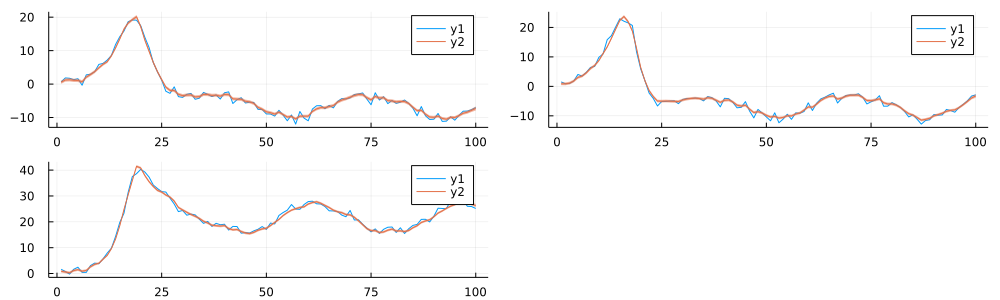

In [25]:
# test after training
index = 1
x_est, f_est = inference(testset[index], W1,b1,W3,b3)

gx, gy, gz = zeros(100), zeros(100), zeros(100)
rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    gx[i], gy[i], gz[i] = noise_free_testset[index][i][1], noise_free_testset[index][i][2], noise_free_testset[index][i][3]
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

# p1 = plot(gx) 
p1 = plot(rx)
p1 = plot!(rx_est_m, ribbon=rx_est_var)

p2 = plot(ry)
p2 = plot!(ry_est_m, ribbon=ry_est_var)

p3 = plot(rz)
p3 = plot!(rz_est_m, ribbon=rz_est_var)

plot(p1, p2, p3, size = (1000, 300))